In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
# csv_files = ['md-knn', 'nw', 'stencil2d-inner', 'md-grid']
# benches = ['md-knn', 'nw', 'stencil-stencil2d', 'md-grid']
csv_files = ['md-knn-summary', 'md-grid-summary', 'stencil2d-inner-summary']
benches = ['md-knn', 'md-grid']

In [4]:
dfs = { f : pd.read_csv(f"{f}.csv") for f in csv_files }

In [5]:
for key in dfs:
    dfs[key]['avg_latency'] = ((dfs[key]['min_latency'] + dfs[key]['max_latency']) /  2)

In [12]:
def find_pareto(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        (before, after) = costs[:i], costs[i+1:]
        # All points such that there is no point which has at least one objective minimized better and other objectives at least equal.
        is_efficient[i] = np.all(np.logical_not(np.logical_and(np.all(before <= c, axis=1), np.any(before < c, axis=1)))) and \
                          np.all(np.logical_not(np.logical_and(np.all(after <= c, axis=1), np.any(after < c, axis=1))))
    return is_efficient

resources = ['bram_used', 'dsp48_used', 'ff_used', 'lut_used', 'avg_latency']

sns.set()
def lut_res_plot(data, keys, to_save=None, name="", legend="xxx", both=False, xproc=lambda x: int(x / 10 ** 3), xlabel='thousands of ', title='XXX'):
    opts = find_pareto(data[resources].to_numpy())
    pareto = data.iloc[opts]

    for key in keys:
        pal = sns.cubehelix_palette(len(data[key].unique()))
        fig = plt.figure()
        ax = fig.gca()
#         ax.title(name)
        for idx, val in enumerate(sorted(data[key].unique())):
#             if both: 
#                 sns.scatterplot(x='avg_latency', y='lut_used', data=pareto[pareto[key] == val], rasterized=True, color=pal[idx])

            sns.scatterplot(x='avg_latency', y='lut_used', data=pareto[pareto[key] == val], rasterized=True, label=str(val), color=pal[idx], ax=ax)
        if key != to_save:
            ax.legend(title=key)
        else:
            ax.legend(title=legend)
        ax.set_title(title)
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(xproc(x), ',')))
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax.set_xlabel(f'Estimated latency ({xlabel}cycles)')
        ax.set_ylabel('Estimate LUTs')
        if key == to_save:
            fig.savefig(f'dahlia-dse-{name}.pdf', dpi=600)

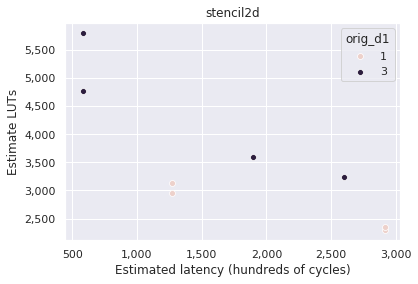

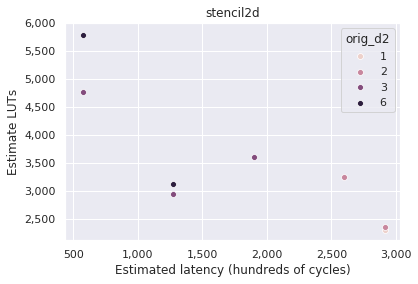

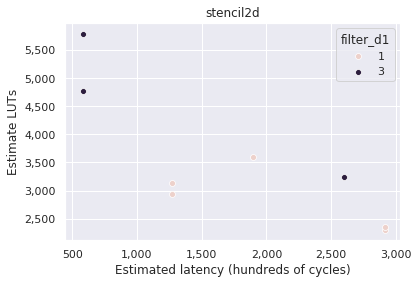

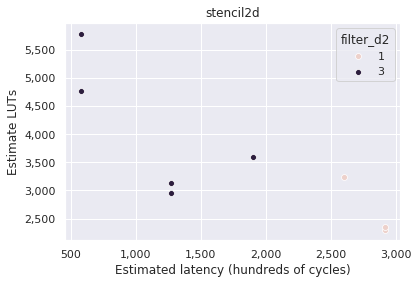

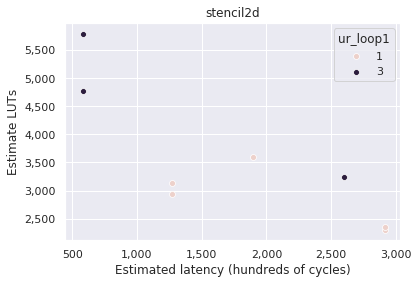

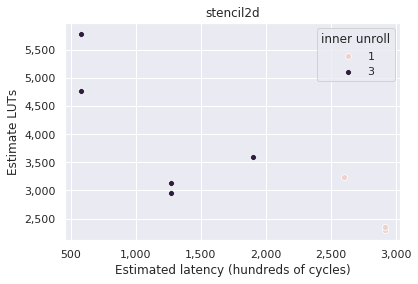

In [13]:
res = ['orig_d1', 'orig_d2', 'filter_d1', 'filter_d2', 'ur_loop1', 'ur_loop2']
lut_res_plot(dfs['stencil2d-inner-summary'], 
             res, 
             title='stencil2d',
             to_save='ur_loop2', 
             legend='inner unroll', 
             name='stencil2d-inner',
             xproc=lambda x: int(x / 100),
             xlabel="hundreds of "
            )

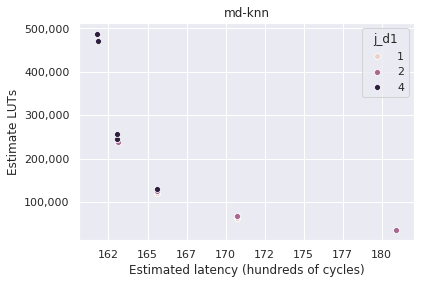

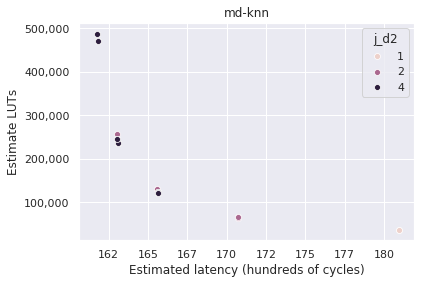

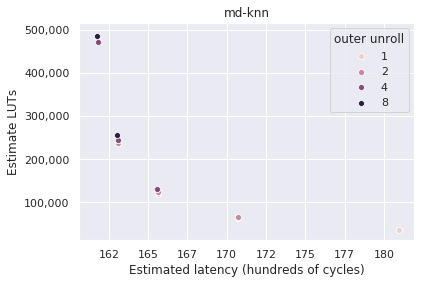

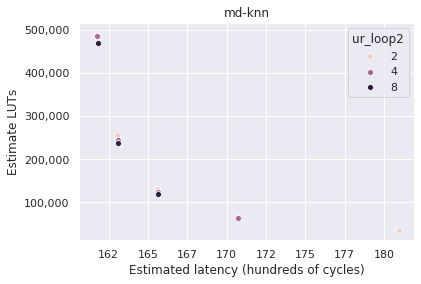

In [14]:
res = ['j_d1', 'j_d2', 'ur_loop1', 'ur_loop2']
df = dfs['md-knn-summary']
# df.lut_used = df.lut_used.apply(lambda x: np.log(x))
lut_res_plot(df[df.avg_latency < 100000], 
             res, 
             title='md-knn',
             to_save='ur_loop1', 
             legend='outer unroll', 
             name='md-knn', 
             both=True, 
             xproc=lambda x: int(x / 100), 
             xlabel="hundreds of ")

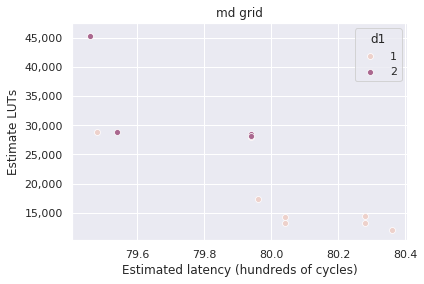

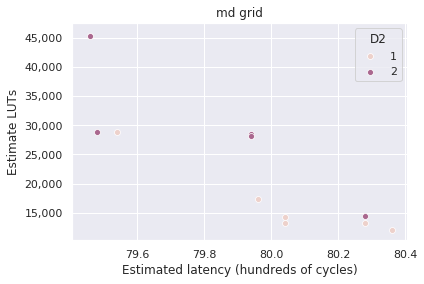

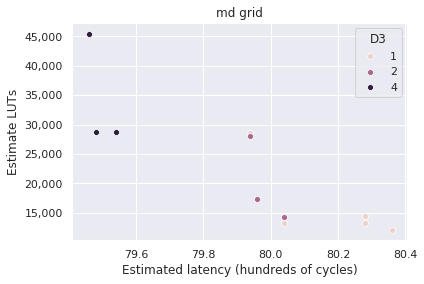

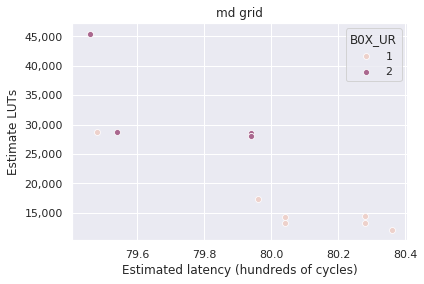

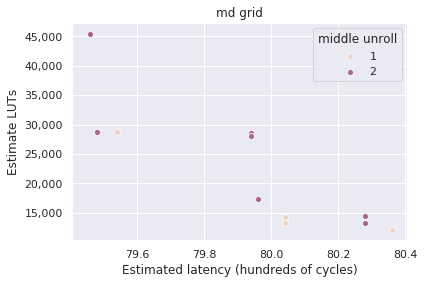

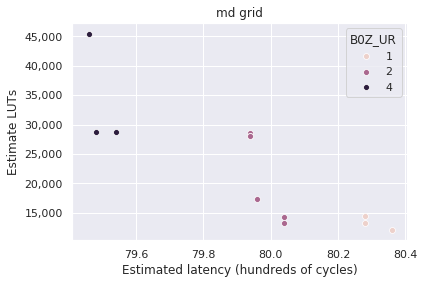

In [15]:
res = ['d1', 'D2', 'D3', 'B0X_UR', 'B0Y_UR', 'B0Z_UR']
lut_res_plot(dfs['md-grid-summary'], 
             res, 
             title='md grid',
             to_save='B0Y_UR', 
             legend='middle unroll', 
             name='md-grid', 
             both=True, 
             xproc=lambda x: x / 100, 
             xlabel='hundreds of ')

In [245]:
data = dfs['md-knn-summary']
data
# opts = find_pareto(data[resources].to_numpy())
# pareto = data.iloc[opts]
# len(data[data.avg_latency < 120000])

,force,pos,j_d1,j_d2,ur_loop1,ur_loop2,bench,target_clock,estimated_clock,min_latency,max_latency,bram_used,dsp48_used,ff_used,lut_used,avg_latency
0,2,1,4,4,1,4,md-knn-ur:machsuite-md-knn-1-0-3-3-0-3,4.0,2.920,16564,16564,504,1184,198302,122470,16564.0
1,1,1,1,4,2,4,md-knn-ur:machsuite-md-knn-0-0-0-3-1-3,4.0,2.920,16562,16562,648,1184,223609,124276,16562.0
2,4,1,2,1,1,2,md-knn-ur:machsuite-md-knn-3-0-1-0-0-1,4.0,2.920,18094,18094,372,296,70767,36021,18094.0
3,4,4,4,4,2,1,md-knn-ur:machsuite-md-knn-3-3-3-3-1-0,4.0,3.554,128651,128651,166,14,13522,10659,128651.0
4,2,4,4,4,2,8,md-knn-ur:machsuite-md-knn-1-3-3-3-1-7,4.0,2.920,16308,16308,804,2368,393401,242254,16308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,2,2,1,1,2,1,md-knn-ur:machsuite-md-knn-1-1-0-0-1-0,4.0,3.554,132747,132747,91,14,13383,9132,132747.0
521,1,4,4,4,1,2,md-knn-ur:machsuite-md-knn-0-3-3-3-0-1,4.0,2.920,16564,16564,516,1184,198311,122527,16564.0
522,1,1,2,2,1,4,md-knn-ur:machsuite-md-knn-0-0-1-1-0-3,4.0,2.920,17074,17074,354,592,113323,65007,17074.0
523,2,1,4,1,1,1,md-knn-ur:machsuite-md-knn-1-0-3-0-0-0,4.0,3.166,128779,128779,88,14,12615,8739,128779.0


In [ ]:
plt.figure()
key = 'B0Z_UR'

sns.scatterplot(x='avg_time', y='lut_used', data=dfs['md-grid-summary'], hue=key, rasterized=True)
# plt.axvline(dfs['md-grid-summary'][dfs['md-grid-summary'][key] == 1].avg_latency.mean(), color='pink')
# plt.axvline(dfs['md-grid-summary'][dfs['md-grid-summary'][key] == 2].avg_latency.mean(), color='red')
# plt.axvline(dfs['md-grid-summary'][dfs['md-grid-summary'][key] == 4].avg_latency.mean(), color='black')

# plt.figure()
# sns.scatterplot(x='avg_latency', y='lut_used', data=dfs['md-grid-summary'], hue=key, rasterized=True)
plt.axhline(dfs['md-grid-summary'][dfs['md-grid-summary'][key] == 1].lut_used.mean(), color='pink')
plt.axhline(dfs['md-grid-summary'][dfs['md-grid-summary'][key] == 2].lut_used.mean(), color='red')
plt.axhline(dfs['md-grid-summary'][dfs['md-grid-summary'][key] == 4].lut_used.mean(), color='black')

# sns.regplot(x='avg_latency', y='lut_used', data=dfs['md-grid-summary'][dfs['md-grid-summary'].d1 == 1])
# sns.regplot(x='avg_latency', y='lut_used', data=dfs['md-grid-summary'][dfs['md-grid-summary'].d1 == 2])
# sns.regplot(x='avg_latency', y='lut_used', data=dfs['md-grid-summary'][dfs['md-grid-summary'].d1 == 4])

plt.savefig('dahlia-dse-md-grid.pdf', dpi=600)

In [20]:
dfs['md-grid-summary'].sort_values(by=['d1', 'D2', 'D3', 'B0X_UR', 'B0Y_UR', 'B0Z_UR'])

,d1,D2,D3,B0X_UR,B0Y_UR,B0Z_UR,bench,target_clock,estimated_clock,min_latency,max_latency,bram_used,dsp48_used,ff_used,lut_used,avg_cycles,avg_time
45,1,1,1,1,1,1,md-grid-ur:machsuite-md-grid-0-0-0-0-0-0,4.0,3.166,6884,9188,41,20,18853,11966,8036.0,25441.976
9,1,1,1,1,1,2,md-grid-ur:machsuite-md-grid-0-0-0-0-0-1,4.0,3.554,6852,9156,41,20,23273,13312,8004.0,28446.216
47,1,1,1,1,2,1,md-grid-ur:machsuite-md-grid-0-0-0-0-1-0,4.0,3.554,6876,9180,41,20,23277,13209,8028.0,28531.512
5,1,1,1,2,1,1,md-grid-ur:machsuite-md-grid-0-0-0-1-0-0,4.0,3.554,6882,9186,41,20,23278,13356,8034.0,28552.836
22,1,1,2,1,1,2,md-grid-ur:machsuite-md-grid-0-0-1-0-0-1,4.0,3.554,6852,9156,40,20,23786,14274,8004.0,28446.216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,4,4,1,4,4,1,md-grid-ur:machsuite-md-grid-3-3-0-2-2-0,4.0,3.432,7979,10667,222,20,86368,49794,9323.0,31996.536
44,4,4,1,4,4,2,md-grid-ur:machsuite-md-grid-3-3-0-2-2-1,4.0,3.720,7947,10635,222,20,155521,84604,9291.0,34562.520
13,4,4,2,4,4,2,md-grid-ur:machsuite-md-grid-3-3-1-2-2-1,4.0,3.720,7947,11019,430,20,163055,75124,9483.0,35276.760
51,4,4,2,4,4,4,md-grid-ur:machsuite-md-grid-3-3-1-2-2-2,4.0,3.834,11739,11739,430,20,300652,125632,11739.0,45007.326


In [ ]:
df_rewrite = pd.read_csv('../../../machsuite-plotting/rewrite/summary.csv')

In [ ]:
df_rewrite

In [ ]:
start = "machsuite" in df_rewrite.bench
for ben in benches:
    start |= df_rewrite.bench == f"rewrite-runtime:machsuite-{ben}"
df_rewrite[start]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

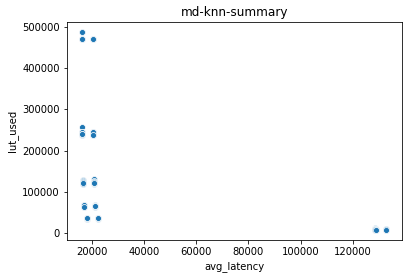

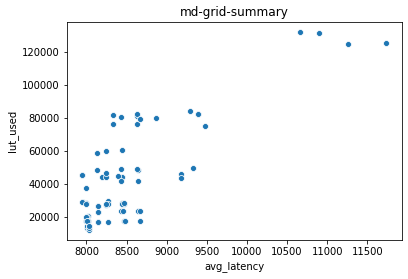

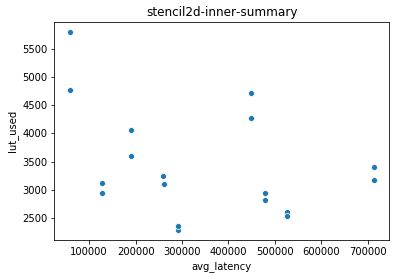

In [33]:
for key in dfs:
    plt.figure()
    sns.scatterplot(x='avg_latency', y='lut_used', data=dfs[key], rasterized=True)
    plt.title(key)
#     plt.savefig(f"{key}.pdf", dpi=600, bbox_inches = "tight")